# PUI Extra Credit Project

Author: Zoe Martiniak (zem232), NYU

Data accessed December 13, 2018

In [81]:
import requests
import os
import sys
import urllib
import pandas as pd
import numpy as np
import geopandas as gp
from shapely.geometry import Point
import pylab as pl
import matplotlib as plt
import datetime
from datetime import datetime
# import Rtree
from geopandas.tools import sjoin
import statsmodels.formula.api as smf
%pylab inline
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
## Downloading NYC Registered Business Data (NYC Open Data)
url = 'https://data.cityofnewyork.us/api/views/w7w3-xahh/rows.csv?accessType=DOWNLOAD'
filename = 'NYCbusinesses.csv'
! rm 'NYCbusinesses.csv'
! rm $PUIDATA/*NYCbusinesses.csv*
urllib.request.urlretrieve(url,filename)
! mv 'NYCbusinesses.csv' $PUIDATA

rm: cannot remove 'NYCbusinesses.csv': No such file or directory


In [3]:
## Downloading Avg. Monthly Neighborhood Rental Prices (Zillow)
url = 'http://files.zillowstatic.com/research/public/Neighborhood/Neighborhood_Zri_AllHomesPlusMultifamily.csv'
filename = 'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
! rm 'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
! rm $PUIDATA/'Neighborhood_Zri_AllHomesPlusMultifamily.csv'
urllib.request.urlretrieve(url,filename)
! mv 'Neighborhood_Zri_AllHomesPlusMultifamily.csv' $PUIDATA

rm: cannot remove 'Neighborhood_Zri_AllHomesPlusMultifamily.csv': No such file or directory


In [4]:
## Downloading Zillow Shapefiles
! rm 'ZillowNeighborhoods-NY.zip'
! rm $PUIDATA/*ZillowNeighborhoods-NY*
url = 'https://www.zillowstatic.com/static-neighborhood-boundaries/LATEST/static-neighborhood-boundaries/shp/ZillowNeighborhoods-NY.zip'
filename = 'ZillowNeighborhoods-NY.zip'
urllib.request.urlretrieve(url,filename)
! unzip 'ZillowNeighborhoods-NY.zip' -d $PUIDATA


Archive:  ZillowNeighborhoods-NY.zip
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.prj  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.shp  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.shx  
  inflating: /nfshome/zem232/PUIdata/ZillowNeighborhoods-NY.dbf  


In [2]:
ZILLOW = pd.read_csv(os.getenv('PUIDATA') + '/Neighborhood_Zri_AllHomesPlusMultifamily.csv')
ZILLOW['RegionID'] = ZILLOW['RegionID'].astype(str)
ZILLOW = ZILLOW[ZILLOW['City']=='New York']
ZILLOW.drop(['State','City','Metro','CountyName'],axis=1, inplace=True)


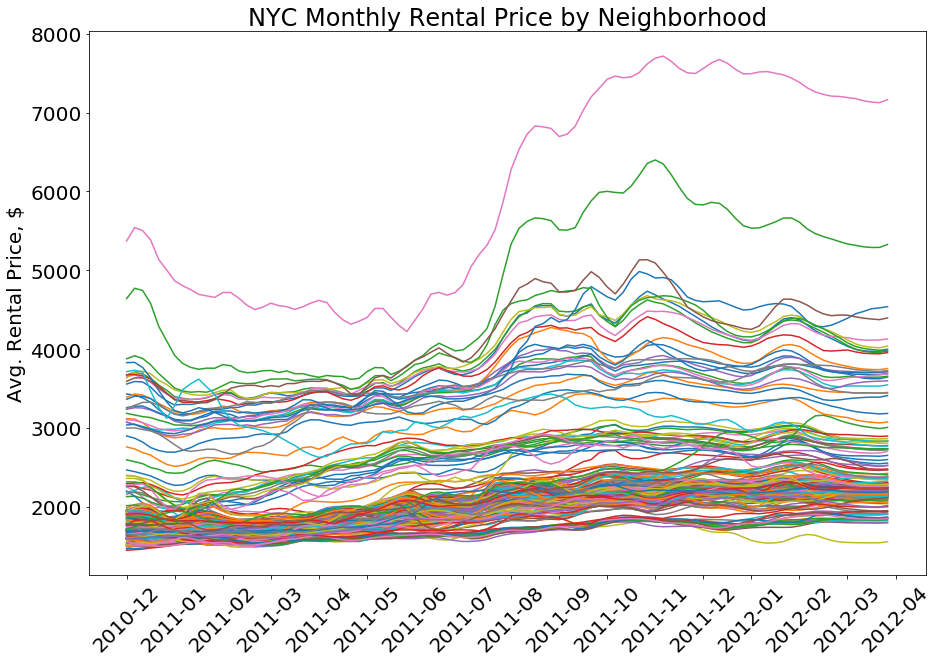

In [3]:

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[3:]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
for i in ZILLOW.index:
    y = ZILLOW[ZILLOW.index == i].T.values[3:]
    ax.plot(x,y)

max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Avg. Rental Price, $')
plt.title('NYC Monthly Rental Price by Neighborhood')
plt.savefig("Monthly Rental Price by Neighborhood.jpeg", bbox_inches='tight')

In [4]:
DROPPED = ZILLOW.drop(['RegionID','RegionName','SizeRank'],axis=1).T

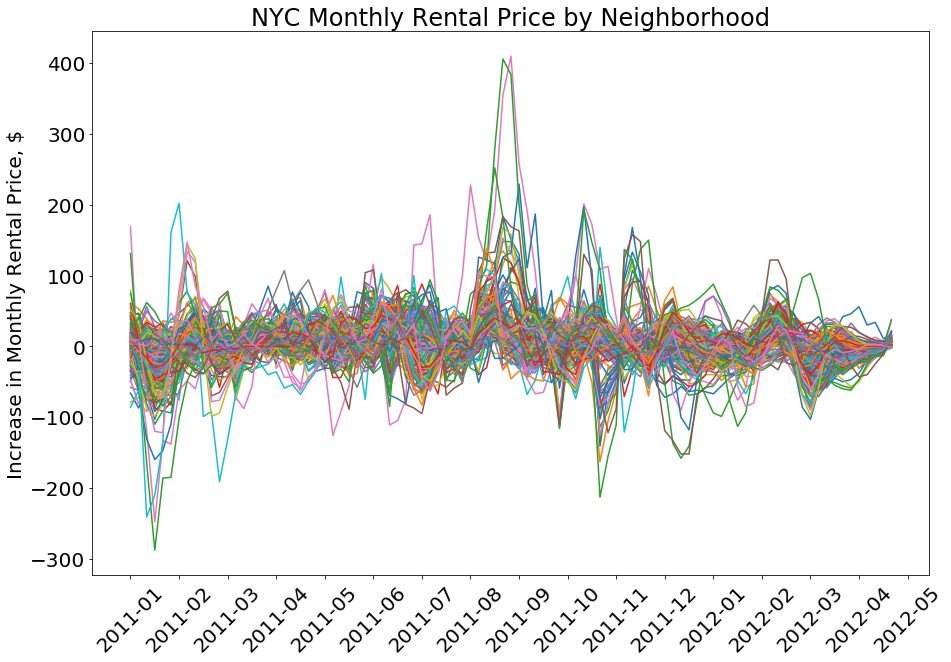

In [5]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[4:]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']
df = pd.DataFrame(index = ZILLOW.index)
trendmin = []
trendmax = []
for i in ZILLOW.index:
    y= []
    for c in range(1,len(DROPPED.index)):
        y.append(DROPPED[i][DROPPED.index[c]]-DROPPED[i][DROPPED.index[c-1]])
    ax.plot(x,y)
    trendmin.append(min(y))
    trendmax.append(max(y))
df['min'] = trendmin
df['max'] = trendmax
max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Increase in Monthly Rental Price, $')
plt.title('NYC Monthly Rental Price by Neighborhood')
plt.savefig("Period Detection.jpeg", bbox_inches='tight')


In [6]:
## Unsurprisingly, the neighborhoods with highest peaks also have highest dips
print(df.sort_values('min').head(10))
print(df.sort_values('max', ascending=False).head(10))

        min    max
1349 -288.0  406.0
609  -248.0  410.0
2865 -241.0  202.0
1571 -213.0  252.0
103  -163.0  135.0
873  -160.0  229.0
2678 -152.0  183.0
194  -141.0  184.0
205  -131.0  148.0
427  -125.0  153.0
        min    max
609  -248.0  410.0
1349 -288.0  406.0
1571 -213.0  252.0
873  -160.0  229.0
2865 -241.0  202.0
194  -141.0  184.0
2678 -152.0  183.0
509  -103.0  168.0
427  -125.0  153.0
205  -131.0  148.0


In [7]:
ZILLOW['PERC_INCR'] = (ZILLOW['2018-10']-ZILLOW['2010-11'])/ZILLOW['2010-11']

In [8]:
TOPGEN = ZILLOW.sort_values('PERC_INCR').tail()
TOPGEN

,RegionID,RegionName,SizeRank,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,PERC_INCR
61,193640,Canarsie,62,1451.0,1458.0,1466.0,1479.0,1489.0,1501.0,1517.0,...,2171,2175,2177,2176,2174,2172,2171,2170,2172,0.496899
16,272902,Bedford Stuyvesant,17,1586.0,1583.0,1577.0,1571.0,1566.0,1574.0,1588.0,...,2467,2443,2420,2404,2392,2386,2381,2377,2386,0.504414
24,403222,Crown Heights,25,1546.0,1543.0,1540.0,1536.0,1539.0,1551.0,1566.0,...,2427,2409,2393,2381,2369,2359,2353,2349,2355,0.523286
953,270857,Hunters Point,954,1706.0,1708.0,1703.0,1701.0,1711.0,1734.0,1781.0,...,2756,2737,2718,2704,2693,2686,2682,2685,2704,0.584994
4782,276623,Utopia,4783,1719.0,1747.0,1786.0,1848.0,1897.0,1925.0,1945.0,...,3163,3137,3097,3066,3042,3021,3007,2994,3009,0.750436


In [9]:
ZILLOWSHP = gp.GeoDataFrame.from_file(os.getenv('PUIDATA') +'/ZillowNeighborhoods-NY.shp')
ZILLOWSHP = ZILLOWSHP[ZILLOWSHP['City']=='New York']
ZILLOWSHP.drop(['State','City'],axis=1, inplace=True)

In [10]:
ZILLOWSHP = ZILLOWSHP.merge(ZILLOW, on='RegionID')

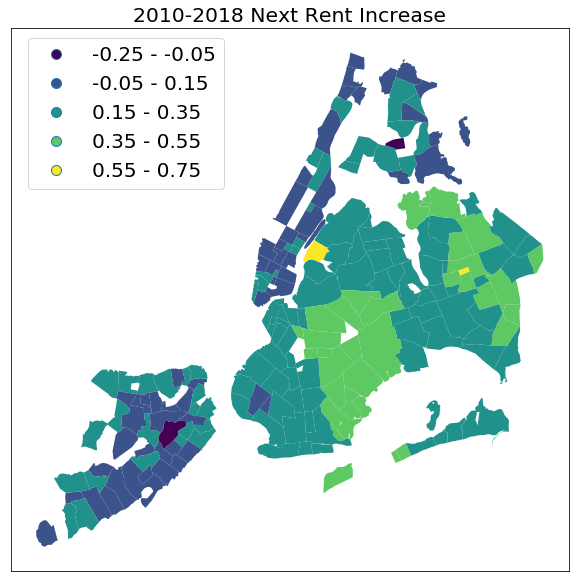

In [11]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ZILLOWSHP.plot(column='PERC_INCR',cmap='viridis',alpha=1,linewidth=0.1,ax=ax, scheme="Equal_interval", legend=True, k=5)
ax.legend(loc='lower left')
pl.rcParams['font.size'] = 17
plt.title("2010-2018 Next Rent Increase")
leg = ax.get_legend()
leg.set_bbox_to_anchor((0, .8, 0.4, 0.2));
plt.savefig("Rent Increase.jpeg", bbox_inches='tight')


In [24]:
TOPGEN = ZILLOW.sort_values('PERC_INCR').tail()
TOPGEN

,RegionID,RegionName,SizeRank,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,...,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08,2018-09,2018-10,PERC_INCR
61,193640,Canarsie,62,1451.0,1458.0,1466.0,1479.0,1489.0,1501.0,1517.0,...,2171,2175,2177,2176,2174,2172,2171,2170,2172,0.496899
16,272902,Bedford Stuyvesant,17,1586.0,1583.0,1577.0,1571.0,1566.0,1574.0,1588.0,...,2467,2443,2420,2404,2392,2386,2381,2377,2386,0.504414
24,403222,Crown Heights,25,1546.0,1543.0,1540.0,1536.0,1539.0,1551.0,1566.0,...,2427,2409,2393,2381,2369,2359,2353,2349,2355,0.523286
953,270857,Hunters Point,954,1706.0,1708.0,1703.0,1701.0,1711.0,1734.0,1781.0,...,2756,2737,2718,2704,2693,2686,2682,2685,2704,0.584994
4782,276623,Utopia,4783,1719.0,1747.0,1786.0,1848.0,1897.0,1925.0,1945.0,...,3163,3137,3097,3066,3042,3021,3007,2994,3009,0.750436


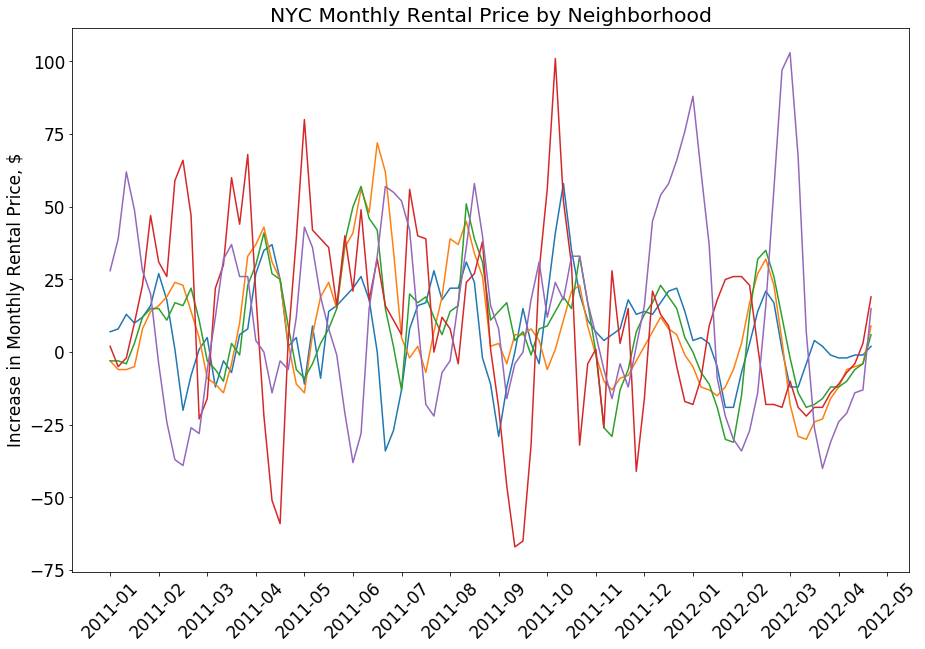

In [25]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

x = ZILLOW.columns[4:-1]
minor_ticks = ['2010','2011','2012','2013','2014','2015','2016','2017','2018']

for i in TOPGEN.index:
    y= []
    for c in range(1,len(DROPPED.index)):
        y.append(DROPPED[i][DROPPED.index[c]]-DROPPED[i][DROPPED.index[c-1]])
    ax.plot(x,y)

max_ticks = 20
xloc = plt.MaxNLocator(max_ticks)
ax.xaxis.set_major_locator(xloc)
plt.xticks(rotation=45)
plt.ylabel('Increase in Monthly Rental Price, $')
plt.title('NYC Monthly Rental Price by Neighborhood')
plt.savefig("Top_Gentr_Neighborhoods.jpeg", bbox_inches='tight')

In [12]:
NYCBIZ = pd.read_csv(os.getenv('PUIDATA') + '/NYCbusinesses.csv')

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
NYCBIZ = NYCBIZ[NYCBIZ['Latitude']>0]
NYCBIZ = NYCBIZ[NYCBIZ['Longitude']>-75]
NYCBIZ.drop(['DCA License Number','Address Building', 'Address Street Name',
       'Secondary Address Street Name','Address City', 'Address State','Contact Phone Number',
            'Borough Code', 'Community Board', 'Council District', 'BIN', 'BBL'], axis=1, inplace=True)

In [14]:
IND = NYCBIZ['Industry'].unique()

In [15]:
for x in range(len(IND)):
    if len(NYCBIZ[NYCBIZ['Industry'] == IND[x]]) < 800:
        print('Deleting %s (only %i entries))'
              %(IND[x],len(NYCBIZ[NYCBIZ['Industry'] == IND[x]])))
        NYCBIZ = NYCBIZ[NYCBIZ['Industry'] != IND[x]]


Deleting Amusement Device Permanent (only 174 entries))
Deleting Pedicab Business (only 397 entries))
Deleting Cabaret (only 162 entries))
Deleting Games of Chance (only 115 entries))
Deleting Tow Truck Company (only 760 entries))
Deleting Debt Collection Agency (only 300 entries))
Deleting Newsstand (only 375 entries))
Deleting Amusement Device Temporary (only 296 entries))
Deleting Horse Drawn Cab Owner (only 93 entries))
Deleting Employment Agency (only 515 entries))
Deleting Sightseeing Bus (only 23 entries))
Deleting Special Sale (only 182 entries))
Deleting Pawnbroker (only 550 entries))
Deleting Pool or Billiard Room (only 81 entries))
Deleting Amusement Device Portable (only 656 entries))
Deleting Car Wash (only 138 entries))
Deleting Parking Lot (only 644 entries))
Deleting Secondhand Dealer - Firearms (only 8 entries))
Deleting Catering Establishment (only 64 entries))
Deleting Process Serving Agency (only 88 entries))
Deleting Tow Truck Exemption (only 54 entries))
Deleting 

In [16]:
NYCBIZ[NYCBIZ.Industry == 'Tobacco Retail Dealer'].count()

License Type               14677
License Expiration Date    14676
License Status             14677
License Creation Date      14677
Industry                   14677
Business Name              14676
Business Name 2             3257
Address ZIP                14677
Address Borough            14677
NTA                        14043
Census Tract               14043
Detail                         0
Longitude                  14677
Latitude                   14677
Location                   14677
dtype: int64

In [26]:
NYCBIZ.dropna(subset=['Business Name'], axis=0,inplace=True)
NYCBIZ.drop(['License Type','Address ZIP', 'Address Borough', 'NTA', 'Census Tract']
           ,axis=1, inplace=True)

In [29]:
NYCBIZ['License Creation']=pd.to_datetime(NYCBIZ['License Creation Date'])
NYCBIZ['License Expiration'] = pd.to_datetime(NYCBIZ['License Expiration Date'])
NYCBIZ.drop(['License Expiration Date','License Creation Date'],axis=1, inplace=True)


In [ ]:
#affkeys = np.array(list(NYCBIZ['Business Name'].keys())).astype(int)
#gg=[(k, NYCBIZ['Business Name'][k]) for k in NYCBIZ.index if 'GROCER' in NYCBIZ['Business Name'][k] or 'FOOD' in NYCBIZ['Business Name'][k] or 'PRODUCE' in NYCBIZ['Business Name'][k]] 
    #and 'DELI' not in NYCBIZ['Business Name'][k]]
#len(gg)


6264

In [ ]:
for i in range(len(gg)):
    NYCBIZ['Industry'][gg[i][0]] = 'Grocery'

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
geometry = [Point(xy) for xy in zip(NYCBIZ.Longitude, NYCBIZ.Latitude)]
crs = {'init':'epsg:4326'}
NYCBIZ = gp.GeoDataFrame(NYCBIZ, crs=crs, geometry=geometry)
NYCBIZ.drop(['Longitude','Latitude','Location'],axis=1,inplace=True)

In [19]:
ZILLOWSHP = ZILLOWSHP.to_crs(epsg=4326)
NYCBIZ = NYCBIZ.to_crs(epsg=4326)

In [20]:
ZILLOWSHP.crs

{'init': 'epsg:4326', 'no_defs': True}

In [21]:
NYCBIZ.crs

{'init': 'epsg:4326', 'no_defs': True}

In [48]:
#SJOINED = gp.sjoin(ZILLOWSHP,NYCBIZ)
PostGen_SJOINED = SJOINED[SJOINED['License Creation']>datetime(2015,1,1)]
PreGen_SJOINED = SJOINED[SJOINED['License Creation']<datetime(2015,1,1) ]


In [49]:
cols_to_drop = [i for i in SJOINED.columns.values if i 
                !='Name' and i !='geometry' and i != 'RegionID' 
                and i !='Industry']
PreGen_SJOINED.drop(cols_to_drop,axis=1,inplace=True)
PostGen_SJOINED.drop(cols_to_drop,axis=1,inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [64]:
df_Post=pd.DataFrame()
for x in PostGen_SJOINED.Industry.unique():
    df_Post[x] =PostGen_SJOINED[PostGen_SJOINED.Industry==x].groupby(['Name'])['Industry'].count()

In [65]:
df_Pre=pd.DataFrame()
for x in PreGen_SJOINED.Industry.unique():
    df[x] =PreGen_SJOINED[PreGen_SJOINED.Industry==x].groupby(['Name'])['Industry'].count()

In [73]:
cols_to_drop = [i for i in ZILLOW.columns.values if i 
                !='RegionID' and i !='RegionName' and i != 'SizeRank' 
                and i !='2018-10' and i !='PERC_INCR']
ZILLOW.drop(cols_to_drop,axis=1, inplace=True)

In [76]:
df_Post['Name']=df_Post.index

In [80]:
merged_Post = df_Post.merge(ZILLOW, left_on='Name', right_on='RegionName')
merged_Post.set_index('Name')
merged_Post.drop(['RegionID','RegionName'],axis=1, inplace=True)

In [95]:
merged_Post.rename(columns={'Stoop Line Stand': 'Stoop', 'Tobacco Retail Dealer':'Tobacco',
       'Home Improvement Contractor':'Home', 'Electronic Cigarette Dealer':'E-cig',
       'Electronic & Appliance Service':'Electronic', 'Electronics Store':'Elec',
       'Dealer In Products':'DIP', 'Secondhand Dealer - General':'Second', 
       'Laundry Jobber':'LaundJob', 'Sidewalk Cafe':'Sidewalk',
       'Secondhand Dealer - Auto':'Auto', '2018-10':'Nov_2018_'},inplace=True)

In [101]:
merged_Post.fillna(0,inplace=True)

In [104]:
merged_Post.corr()

,Laundries,Stoop,Tobacco,Home,E-cig,Electronic,Elec,DIP,Second,Garage,Laundry,LaundJob,Sidewalk,Auto,SizeRank,Nov_2018_,PERC_INCR
Laundries,1.000000,0.633380,0.669064,0.553413,0.759556,0.569349,0.589441,0.360574,0.535171,0.676921,0.648711,0.778277,0.736894,0.249708,-0.423722,0.171641,0.085117
Stoop,0.633380,1.000000,0.599374,0.568304,0.493773,0.799283,0.784611,0.468313,0.600504,0.238259,0.662162,0.262008,0.254782,0.265027,-0.416450,-0.034590,0.144391
Tobacco,0.669064,0.599374,1.000000,0.540583,0.682368,0.763346,0.829991,0.287594,0.738075,0.287424,0.736800,0.310690,0.363281,0.389082,-0.443763,0.034103,0.210970
Home,0.553413,0.568304,0.540583,1.000000,0.495085,0.660211,0.633948,0.512092,0.553595,0.093470,0.633345,0.169691,0.168391,0.404307,-0.459374,-0.129047,0.283438
E-cig,0.759556,0.493773,0.682368,0.495085,1.000000,0.611336,0.576290,0.324948,0.624217,0.599647,0.476886,0.600596,0.702305,0.165168,-0.378520,0.339189,-0.040797
Electronic,0.569349,0.799283,0.763346,0.660211,0.611336,1.000000,0.945614,0.441050,0.772852,0.222577,0.684150,0.182405,0.201600,0.356583,-0.382438,-0.008008,0.146290
Elec,0.589441,0.784611,0.829991,0.633948,0.576290,0.945614,1.000000,0.410661,0.800850,0.201195,0.771797,0.179681,0.206842,0.391972,-0.427908,-0.032371,0.186896
DIP,0.360574,0.468313,0.287594,0.512092,0.324948,0.441050,0.410661,1.000000,0.327214,0.119207,0.366548,0.176827,0.059748,0.143763,-0.340996,-0.057531,0.187764
Second,0.535171,0.600504,0.738075,0.553595,0.624217,0.772852,0.800850,0.327214,1.000000,0.353923,0.646512,0.234855,0.256812,0.452257,-0.382135,0.082252,0.125280
Garage,0.676921,0.238259,0.287424,0.093470,0.599647,0.222577,0.201195,0.119207,0.353923,1.000000,0.074921,0.844170,0.732710,-0.088784,-0.185024,0.396510,-0.146653


In [105]:
mod = smf.ols(formula='PERC_INCR ~ Laundries + Stoop+Tobacco+Home+Electronic+Elec+DIP+Second+Garage+Laundry+LaundJob+Sidewalk+Auto+Name+SizeRank+ Nov_2018_', data = merged_Post).fit()
print(mod.summary())


                            OLS Regression Results                            
Dep. Variable:              PERC_INCR   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.548
Method:                 Least Squares   F-statistic:                     2.221
Date:                Fri, 14 Dec 2018   Prob (F-statistic):              0.497
Time:                        23:29:36   Log-Likelihood:                 708.03
No. Observations:                 192   AIC:                            -1034.
Df Residuals:                       1   BIC:                            -411.9
Df Model:                         190                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------

pointsin = []
biz = NYCBIZ.copy()
for i, poly in ZILLOWSHP.iterrows():
    pointsinthispoly=[]
    for j, pt in biz.iterrows():
        if poly.geometry.contains(pt.geometry):
            pointsinthispoly.append(pt.geometry)
            biz = biz.drop([j])
    pointsin.append(len(pointsinthispoly))

In [ ]:
f, ax = plt.subplots(1, figsize=(15,15))
#ax.set_axis_off()
plt.axis('equal')
#ZILLOWSHP.plot(ax=ax, column='2018-10',cmap='cool',alpha=1,
                  #linewidth=0.1,scheme="quantiles", legend=True, k=10)
# Plot the linkNYC stations over the chlorpleth
# Stations are color installed, using the date_link column
#### Can't show the legend though, otherwise it overwrites the choropleth legend.. :/
NYCBIZ.plot(markersize=15, ax=ax)
plt.title("Density of LinkNYC Stations Per Capita in PUMA Sectors", fontsize=20);